<a href="https://colab.research.google.com/github/dheerajy2310/Circular-Notification-System/blob/master/CNN_Skin_Cancer_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import tensorflow as tf
import keras.preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator
from google.colab import files
import zipfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.utils.data_utils import get_file
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras import Model,models

In [2]:
# files.upload()

!pip install -q kaggle 
# !pip install kaggle
!mkdir ~/.kaggle
!cp -r /content/drive/MyDrive/Kaggle/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# import os
# os.environ['KAGGLE_CONFIG_DIR']='/content/drive/MyDrive/Kaggle'

# %cd /content/drive/MyDrive/Kaggle

In [4]:
!kaggle datasets download -d gabrielmv/skin-cancer

100% 5.16G/5.16G [01:48<00:00, 42.4MB/s]
100% 5.16G/5.16G [01:48<00:00, 51.2MB/s]


In [5]:
#augmented skin cancer dataset of 9 classes with 9K images

# !kaggle datasets download -d ayaanmustafa/augmented-skincancer-isic

In [6]:
with zipfile.ZipFile('/content/skin-cancer.zip') as zp:
  zp.extractall('/content/skin-cancer')

# !unzip /content/drive/MyDrive/Kaggle/skin-cancer.zip

In [7]:
# VGG16

# vgg=VGG16(input_shape=(224,224,3),weights='imagenet')
 
# vgg.layers[0].trainable=False
  
# vgg.summary()


In [8]:
initialUse=True

In [9]:
if initialUse:
  resnet_model=ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3))
  for i in range(175):

    resnet_model.layers[i].trainable=False
  resnet_model.summary()
else:
  model=tf.keras.load_model('/content/drive/MyDrive/Kaggle/SkinCancerModel.hdf5')
  #load weights from drive

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [10]:


# model=tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(16,(3,3),input_shape=(150,150,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(256,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Conv2D(512,(3,3),activation='relu'),
#     tf.keras.layers.MaxPooling2D(2,2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(512,activation='relu'),
#     tf.keras.layers.Dense(256,activation='relu'),
#     tf.keras.layers.Dense(128,activation='relu'),
#     tf.keras.layers.Dense(64,activation='relu'),
#     tf.keras.layers.Dense(32,activation='relu'),
#     tf.keras.layers.Dense(7,activation='softmax')
# ])
if initialUse:
  model=models.Sequential()
  model.add(tf.keras.layers.Lambda(lambda image: tf.image.resize(image, (224,224))))
  model.add(resnet_model)
  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dropout(0.2))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(256,activation='relu',))
  # model.add(tf.keras.layers.Dropout(0.2))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(128,activation='relu',))
  model.add(tf.keras.layers.Dropout(0.2))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(64,activation='relu',))
  # model.add(tf.keras.layers.Dropout(0.4))
  # model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Dense(7,activation='softmax',))
  model.build(input_shape=(None,224,224,3))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dropout (Dropout)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               25690368  
_________________________________________________________________
dense_1 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

In [11]:
trainingDir="/content/skin-cancer/dataset/train"
testingDir="/content/skin-cancer/dataset/valid"

train_Data_generator=ImageDataGenerator(
    rescale=1/255,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    fill_mode="nearest"
)

valid_Data_generator=ImageDataGenerator(
    rescale=1/255
)

traindata=train_Data_generator.flow_from_directory(
    trainingDir,
    batch_size=32,
    class_mode="categorical",
    target_size=(224,224)
)

validdata=train_Data_generator.flow_from_directory(
    testingDir,
    batch_size=64,
    class_mode="categorical",
    target_size=(224,224)
)

Found 8512 images belonging to 7 classes.
Found 1503 images belonging to 7 classes.


In [12]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
sgd = SGD(learning_rate=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(
    # optimizer= RMSprop(learning_rate=0.001),
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [13]:
class mycallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self,epoch,logs={}):
    if(logs.get('accuracy')>0.70):
      self.model.stop_training=True

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath= '/content/drive/MyDrive/kaggle/'+"SkinCancerModel.hdf5", monitor='loss', verbose=1,save_best_only=True, mode='auto', period=1)

In [14]:
callbacks=mycallback()

history=model.fit(
    traindata, 
    epochs=15,
    steps_per_epoch=256, 
    validation_data=validdata,
    validation_steps=20, 
    verbose=1,
    callbacks=[callbacks,checkpoint_callback]
)

Epoch 1/15
256/256 [==============================] - 1140s 4s/step - loss: 1.4420 - accuracy: 0.6364 - val_loss: 1.1414 - val_accuracy: 0.6711

Epoch 00001: loss improved from inf to 1.44196, saving model to /content/drive/MyDrive/kaggle/SkinCancerModel.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
256/256 [==============================] - 1165s 5s/step - loss: 1.1620 - accuracy: 0.6666 - val_loss: 1.1852 - val_accuracy: 0.6711

Epoch 00002: loss improved from 1.44196 to 1.16202, saving model to /content/drive/MyDrive/kaggle/SkinCancerModel.hdf5
Epoch 3/15
256/256 [==============================] - 1228s 5s/step - loss: 1.1532 - accuracy: 0.6689 - val_loss: 1.1294 - val_accuracy: 0.6695

Epoch 00003: loss improved from 1.16202 to 1.15316, saving model to /content/drive/MyDrive/kaggle/SkinCancerModel.hdf5
Epoch 4/15
256/256 [==============================] - 1229s 5s/step - loss: 1.1339 - accuracy: 0.6704 - val_loss: 1.1269 - val_accuracy: 0.6648

Epoch 00004: loss improved from 1.15316 to 1.13395, saving model to /content/drive/MyDrive/kaggle/SkinCancerModel.hdf5
Epoch 5/15
256/256 [==============================] - 1233s 5s/step - loss: 1.1241 - accuracy: 0.6688 - val_loss: 1.0876 - val_accuracy: 0.6672

Epoch 00005: loss improved from 1.13395 to 1.12412, saving mode

<Figure size 432x288 with 0 Axes>

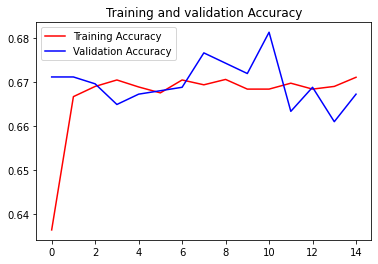

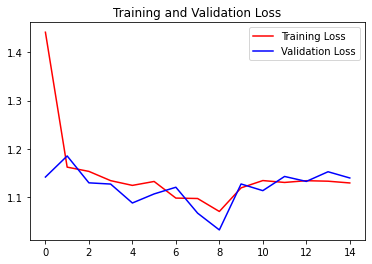

<Figure size 432x288 with 0 Axes>

In [15]:
acc=history.history['accuracy']
loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']


epochs=range(len(acc))

plt.plot(epochs,acc,'r',label='Training Accuracy')
plt.plot(epochs,val_acc,'b',label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend(loc=0)
plt.figure()


plt.plot(epochs,loss,'r',label='Training Loss')
plt.plot(epochs,val_loss,'b',label='Validation Loss')
plt.title('Training and Validation Loss')
# plt.ylim([0.5,2])
plt.legend(loc=0)
plt.figure()

In [16]:
# model.save("skinCNN.h5")

In [17]:
import numpy as np

print(traindata.image_shape,validdata.image_shape)

pred=model.predict(traindata)
validpred=pred.argmax(axis=-1)
print(validpred)


(224, 224, 3) (224, 224, 3)
[5 5 5 ... 5 5 5]


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

